# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
floyd run --gpu --env tensorflow --mode jupyter --data /R5KrjnANiKVhLWAkpXhNBe

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


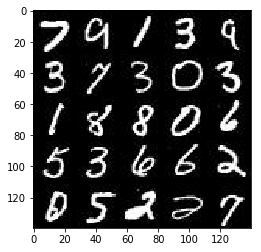

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

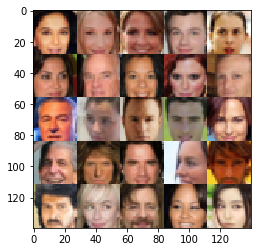

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, x1*alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
#         print(x3.get_shape())
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        
        logits = tf.layers.dense(flat, 1)
#         print(logits.get_shape())
        
        out = tf.sigmoid(logits)
#         out = tf.nn.dropout(out, keep_prob=0.99)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        x1 = tf.reshape(x1, (-1,3,3,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
#         print(x3.get_shape())
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, x4 * alpha)
#         print(x4.get_shape())
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         print(logits.get_shape())
        
        out = tf.tanh(logits)
#         out = tf.nn.dropout(out, keep_prob=0.99)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return images_grid

In [11]:
import scipy.misc
pic_dir = 'images/'
!mkdir images

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    show_every = 100
    print_every = 10
    step = 0
    samples, losses = [], []
    
    img_height = data_shape[1]
    img_width = data_shape[2]
    img_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_height, img_width, img_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        img = show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
        scipy.misc.imsave(pic_dir + 'img_{}.jpg'.format(step), img)
        
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # show image at start
                
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                

                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Step: {}...".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    img = show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
                    scipy.misc.imsave(pic_dir + 'img_{}.jpg'.format(step/show_every), img)
                    
                
        saver.save(sess, './checkpoints/generator.ckpt')       
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [15]:
!mkdir 'checkpoints'

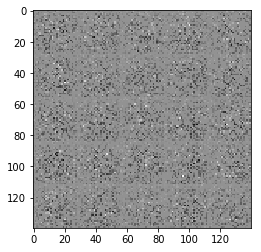

Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 2.6258
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 3.2768
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.4958
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 3.8112


KeyboardInterrupt: 

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

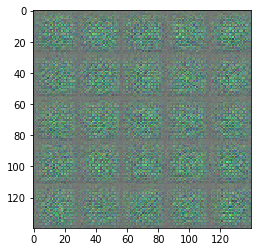

Step: 10... Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 6.4267
Step: 20... Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 6.1035
Step: 30... Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 1.6647
Step: 40... Epoch 1/1... Discriminator Loss: 2.2417... Generator Loss: 0.7279
Step: 50... Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.5594
Step: 60... Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.4598
Step: 70... Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.0124
Step: 80... Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.3482
Step: 90... Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.3946
Step: 100... Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7320


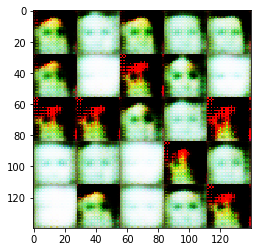

Step: 110... Epoch 1/1... Discriminator Loss: 2.2593... Generator Loss: 0.2455
Step: 120... Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.9573
Step: 130... Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 1.0048
Step: 140... Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.8227
Step: 150... Epoch 1/1... Discriminator Loss: 1.8987... Generator Loss: 1.0473
Step: 160... Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.9629
Step: 170... Epoch 1/1... Discriminator Loss: 1.8603... Generator Loss: 0.5133
Step: 180... Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6990
Step: 190... Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.8796
Step: 200... Epoch 1/1... Discriminator Loss: 1.8072... Generator Loss: 1.7441


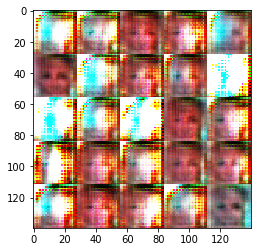

Step: 210... Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7863
Step: 220... Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.5147
Step: 230... Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.5974
Step: 240... Epoch 1/1... Discriminator Loss: 1.9960... Generator Loss: 0.3586
Step: 250... Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7726
Step: 260... Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6662
Step: 270... Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.6856
Step: 280... Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7552
Step: 290... Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.6055
Step: 300... Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9260


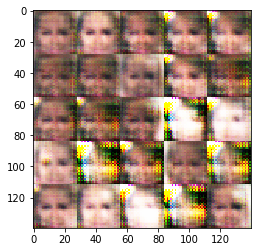

Step: 310... Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.6414
Step: 320... Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.7943
Step: 330... Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.5426
Step: 340... Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6794
Step: 350... Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6070
Step: 360... Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6650
Step: 370... Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.7061
Step: 380... Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.8663
Step: 390... Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7975
Step: 400... Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6543


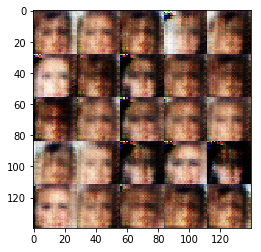

Step: 410... Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 0.6072
Step: 420... Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7032
Step: 430... Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7299
Step: 440... Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.9809
Step: 450... Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.5823
Step: 460... Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.5319
Step: 470... Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6589
Step: 480... Epoch 1/1... Discriminator Loss: 1.8834... Generator Loss: 0.3619
Step: 490... Epoch 1/1... Discriminator Loss: 1.7801... Generator Loss: 0.3928
Step: 500... Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7848


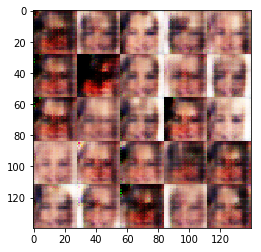

Step: 510... Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6948
Step: 520... Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8582
Step: 530... Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.5398
Step: 540... Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.9482
Step: 550... Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6071
Step: 560... Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7683
Step: 570... Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7625
Step: 580... Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.9147
Step: 590... Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.5267
Step: 600... Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7498


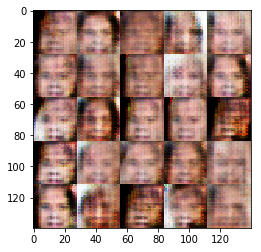

Step: 610... Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7628
Step: 620... Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5545
Step: 630... Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8016
Step: 640... Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8472
Step: 650... Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.1061
Step: 660... Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8156
Step: 670... Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0361
Step: 680... Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8903
Step: 690... Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.8075
Step: 700... Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7972


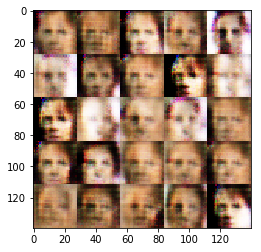

Step: 710... Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6794
Step: 720... Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8923
Step: 730... Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.8510
Step: 740... Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.9828
Step: 750... Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.9216
Step: 760... Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.5467
Step: 770... Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7849
Step: 780... Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.8071
Step: 790... Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7199
Step: 800... Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7506


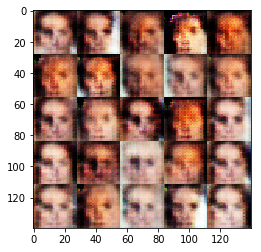

Step: 810... Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7218
Step: 820... Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.6812
Step: 830... Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.8139
Step: 840... Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.8064
Step: 850... Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.8730
Step: 860... Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8085
Step: 870... Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.9073
Step: 880... Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7541
Step: 890... Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.9445
Step: 900... Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8456


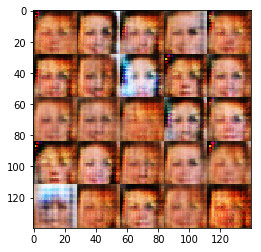

Step: 910... Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.6302
Step: 920... Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7240
Step: 930... Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.6355
Step: 940... Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7118
Step: 950... Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6892
Step: 960... Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.8678
Step: 970... Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.8228
Step: 980... Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7713
Step: 990... Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6448
Step: 1000... Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.9589


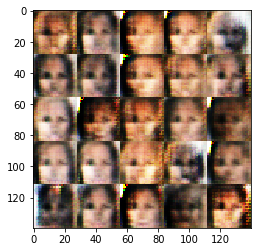

Step: 1010... Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.7251
Step: 1020... Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7900
Step: 1030... Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7124
Step: 1040... Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7732
Step: 1050... Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6473
Step: 1060... Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7550
Step: 1070... Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8073
Step: 1080... Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6778
Step: 1090... Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7814
Step: 1100... Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7254


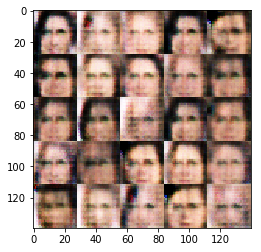

Step: 1110... Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.5612
Step: 1120... Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.9549
Step: 1130... Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8560
Step: 1140... Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7387
Step: 1150... Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.8806
Step: 1160... Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.7980
Step: 1170... Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.6343
Step: 1180... Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.9250
Step: 1190... Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 1.0636
Step: 1200... Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.5460


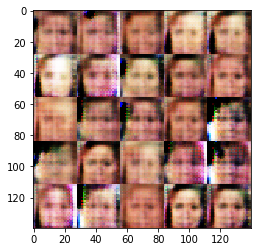

Step: 1210... Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.9061
Step: 1220... Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7964
Step: 1230... Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.9965
Step: 1240... Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.7051
Step: 1250... Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.6640
Step: 1260... Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6669
Step: 1270... Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.7208
Step: 1280... Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8468
Step: 1290... Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7671
Step: 1300... Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6876


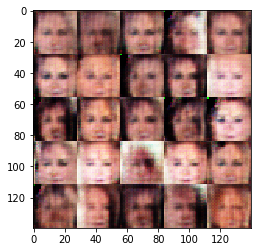

Step: 1310... Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.8471
Step: 1320... Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6860
Step: 1330... Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8116
Step: 1340... Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.4568
Step: 1350... Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7649
Step: 1360... Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.8704
Step: 1370... Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7016
Step: 1380... Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6709
Step: 1390... Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7165
Step: 1400... Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8399


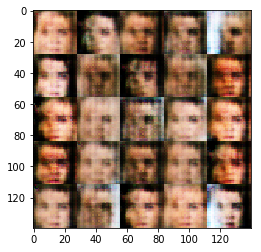

Step: 1410... Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7357
Step: 1420... Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6980
Step: 1430... Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7567
Step: 1440... Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.4864
Step: 1450... Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.5760
Step: 1460... Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.6728
Step: 1470... Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.9512
Step: 1480... Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7611
Step: 1490... Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6847
Step: 1500... Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8019


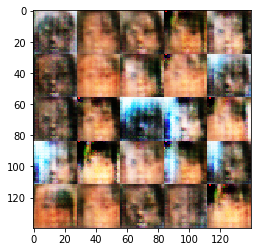

Step: 1510... Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7931
Step: 1520... Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7927
Step: 1530... Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7474
Step: 1540... Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.9419
Step: 1550... Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7805
Step: 1560... Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7542
Step: 1570... Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7738
Step: 1580... Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8732
Step: 1590... Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7094
Step: 1600... Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7534


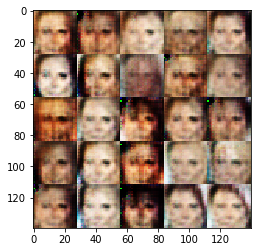

Step: 1610... Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6946
Step: 1620... Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7699
Step: 1630... Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7705
Step: 1640... Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7349
Step: 1650... Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8025
Step: 1660... Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8969
Step: 1670... Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6993
Step: 1680... Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7883
Step: 1690... Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7445
Step: 1700... Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6491


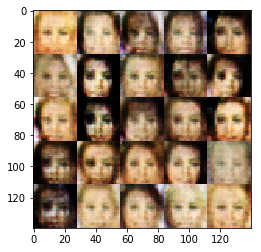

Step: 1710... Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8463
Step: 1720... Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7161
Step: 1730... Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8313
Step: 1740... Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7154
Step: 1750... Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6068
Step: 1760... Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6929
Step: 1770... Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7187
Step: 1780... Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6859
Step: 1790... Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6943
Step: 1800... Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7373


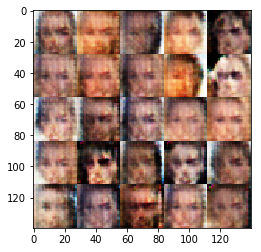

Step: 1810... Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.8443
Step: 1820... Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7962
Step: 1830... Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7784
Step: 1840... Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 1.1884
Step: 1850... Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.8615
Step: 1860... Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7687
Step: 1870... Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7440
Step: 1880... Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7578
Step: 1890... Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.8268
Step: 1900... Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.8364


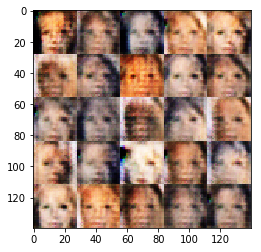

Step: 1910... Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7580
Step: 1920... Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7307
Step: 1930... Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7445
Step: 1940... Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7417
Step: 1950... Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7811
Step: 1960... Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8095
Step: 1970... Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8022
Step: 1980... Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7561
Step: 1990... Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7205
Step: 2000... Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7177


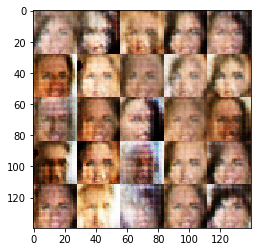

Step: 2010... Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8070
Step: 2020... Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7447
Step: 2030... Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6772
Step: 2040... Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6593
Step: 2050... Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.8706
Step: 2060... Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7756
Step: 2070... Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7810
Step: 2080... Epoch 1/1... Discriminator Loss: 2.0767... Generator Loss: 0.3823
Step: 2090... Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6773
Step: 2100... Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9730


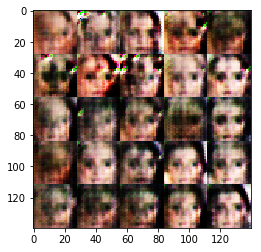

Step: 2110... Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6680
Step: 2120... Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6843
Step: 2130... Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7389
Step: 2140... Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.8404
Step: 2150... Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.9237
Step: 2160... Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8522
Step: 2170... Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7802
Step: 2180... Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6666
Step: 2190... Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7795
Step: 2200... Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8039


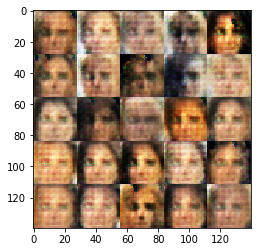

Step: 2210... Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7666
Step: 2220... Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6689
Step: 2230... Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7606
Step: 2240... Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.8080
Step: 2250... Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7572
Step: 2260... Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7110
Step: 2270... Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7615
Step: 2280... Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7749
Step: 2290... Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7395
Step: 2300... Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7269


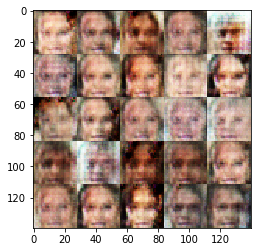

Step: 2310... Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7751
Step: 2320... Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6428


KeyboardInterrupt: 

In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.